# Load and prepare

In [1]:
source("~/public/SiyuanLuo/projects/benchmark/scripts/evaluation/lib_metrics.R")
source("~/public/SiyuanLuo/projects/benchmark/scripts/clustering/lib_clustering.R")
source("utils.R")

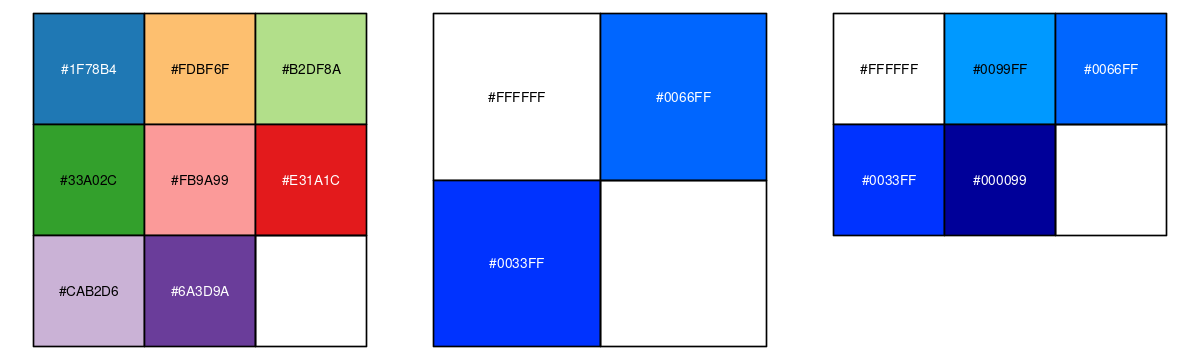

In [2]:
options(repr.plot.width=10, repr.plot.height=3)
par(mfrow=c(1,3))

show_col(my_col_m3)
show_col(my_color_2)
show_col(my_color_3)

In [3]:
dataset_ls <- c("Cell_line_mixing", "candidate1",  "candidate2", "Buenrostro_2018",  "Chen_2019",  "PBMC_multiomics") 
dataset_name <- c("Cell line","Atlas1", "Atlas2","Buenrostro2018","Chen2019","10XPBMC")
k_ls <- c(10, 13, 10, 9, 13, 15)

In [5]:
file1 <- "../result_files/results_meta_data.tsv"
file2 <- "../result_files/results_all_metrics.tsv"
df <- read.table(file1, sep='\t', header=TRUE)
df_metrics <- read.table(file2, sep='\t', header=TRUE)
df_metrics$dataset <- factor(df_metrics$dataset, levels = c("Cell line","Atlas1", "Atlas2","Buenrostro2018","Chen2019","10XPBMC"))
df_metrics$long_method <- factor(df_metrics$long_method, levels=c("aggregation", "SnapATAC", "ArchR_peaks", "ArchR_tiles","Signac_all_cell_peaks","Signac_by_cluster_peaks","SnapATAC2_cosine","SnapATAC2_jaccard"))


## Graph connectivity / PWC

In [6]:
df_g <- read.table("../result_files/graph_metric_all_ndim15.tsv", sep='\t', header=TRUE)
df_gs <- df_g %>% group_by(dataset, method) %>% mutate(average = mean(weak_frac)) %>% subset(select=c(method, dataset, average))
df_gs <- df_gs[!duplicated(df_gs), ]

mapping <- list("Cell line mixing experiment" = "Cell line", 
                     "human adult atlas subset1" = "Atlas1", 
                     "human adult atlas subset2" = "Atlas2",
                     "Buenrostro2018" = "Buenrostro2018",
                     "Chen2019" = "Chen2019",
                     "10X PBMC multiomics" = "10XPBMC")
df_gs <- df_gs %>% 
  mutate(dataset_short = case_when(as.character(dataset) %in% names(mapping) ~ mapping[[as.character(dataset)]],
                             TRUE ~ "Other"))
df_gs$dataset_short <- factor(df_gs$dataset_short, levels = dataset_name)

df_gs$method[df_gs$method=="SnapATAC1"] <- "SnapATAC"
df_gs$method <- factor(df_gs$method, levels=c("aggregation", "SnapATAC", "ArchR_peaks", "ArchR_tiles","Signac_all_cell_peaks","Signac_by_cluster_peaks","SnapATAC2_cosine","SnapATAC2_jaccard"))

head(df_gs)

method,dataset,average,dataset_short
<fct>,<chr>,<dbl>,<fct>
Signac_by_cluster_peaks,Cell line mixing experiment,0.004244095,Cell line
Signac_all_cell_peaks,Cell line mixing experiment,0.004163120,Cell line
ArchR_tiles,Cell line mixing experiment,0.001719935,Cell line
ArchR_peaks,Cell line mixing experiment,0.003004065,Cell line
SnapATAC,Cell line mixing experiment,0.003063441,Cell line
aggregation,Cell line mixing experiment,0.001146118,Cell line


In [7]:
mapping <- list("Cell line" = "1", 
                     "Atlas1" = "1", 
                     "Atlas2" = "1",
                     "Buenrostro2018" = "2",
                     "Chen2019" = "2",
                     "10XPBMC" = "2")
                     
df_gs <- df_gs %>% 
  mutate(dataset_type = case_when(as.character(dataset_short) %in% names(mapping) ~ mapping[as.character(dataset_short)]))
df_gs$dataset_type <- unlist(df_gs$dataset_type)

## Silhoutte score

In [8]:
# Others
df_metrics_silhouette <- df_metrics %>% filter(metric == "Silhouette_label") %>% filter(ndim == 15)
dim(df_metrics_silhouette)

[1] 894  17

In [9]:
df_metrics_silhouette_s <- df_metrics_silhouette %>% 
                            group_by(dataset, long_method) %>% 
                            mutate(average = mean(value)) %>% 
                            subset(select=c(long_method, dataset, average))
df_metrics_silhouette_s <- df_metrics_silhouette_s[!duplicated(df_metrics_silhouette_s), ]
head(df_metrics_silhouette_s)
dim(df_metrics_silhouette_s)

long_method,dataset,average
<fct>,<fct>,<dbl>
Signac_by_cluster_peaks,Cell line,0.3155830
Signac_all_cell_peaks,Cell line,0.3100631
ArchR_tiles,Cell line,0.3800706
ArchR_peaks,Cell line,0.3794470
SnapATAC,Cell line,0.3449951
aggregation,Cell line,0.6487235


[1] 48  3

## Fraction of negative silhouette

In [206]:
# df_metrics_silhouette_tmp <- subset(df_metrics_silhouette, select = c(value, method, long_method, feature_type, tile_size, distance, ndim, rds_file, snn_file, dataset, k_optimal, dataset2))
# df_metrics_silhouette_tmp <- df_metrics_silhouette_tmp[!duplicated(subset(df_metrics_silhouette_tmp, select = -rds_file)), ]
# dim(df_metrics_silhouette_tmp)

# df_hm <- data.frame(cell_type=c(), negative_fraction=c(), long_method=c(), dataset=c(), dataset2=c(), ndim=c())
# for(i in 1:dim(df_metrics_silhouette_tmp)[1]){
#     rds_file <- paste0("~/public/SiyuanLuo/projects/benchmark/outputs/", df_metrics_silhouette_tmp$dataset2[i], "/", df_metrics_silhouette_tmp$rds_file[i])
#     res <- readRDS(rds_file)
#     rpt <- try(df_sil <- data.frame(res$sil$sil)[,c("cluster", "sil_width")])
#     if (class(rpt) == "try-error"){
#         df_sil <- data.frame(res$sil2$sil)[,c("cluster", "sil_width")]
#     }
    
#     snn_file <- paste0("~/public/SiyuanLuo/projects/benchmark/outputs/", df_metrics_silhouette_tmp$dataset2[i], "/", df_metrics_silhouette_tmp$snn_file[i])
#     sobj <- readRDS(snn_file)
#     true_labels <- sobj$ground_truth
    
#     df_sil$cell_type <- unlist(lapply(df_sil$cluster, function(x){levels(true_labels)[x]}))
#     label_colname <- "cell_type"

#     df_sil <- df_sil[order(df_sil[,"cluster"], -df_sil$sil_width), ]
#     df_sil$negative_sil <- df_sil$sil_width < 0

#     df_sil_neg <- df_sil %>%
#     group_by(cell_type) %>%
#     summarise(negative_count = sum(negative_sil), count = n()) 

#     df_sil_neg$negative_fraction <- df_sil_neg$negative_count/df_sil_neg$count
#     df_sil_neg$long_method <- df_metrics_silhouette_tmp$long_method[i]
#     df_sil_neg$dataset <- df_metrics_silhouette_tmp$dataset[i]
#     df_sil_neg$dataset2 <- df_metrics_silhouette_tmp$dataset2[i]
#     df_sil_neg$ndim <- df_metrics_silhouette_tmp$ndim[i]

#     df_hm <- rbind(df_hm, df_sil_neg[,c("cell_type", "negative_fraction", "long_method", "dataset", "dataset2", "ndim")])
# }

# write.table(df_hm, file="Negative_silhouette_frac_all_ndim_all.tsv", sep='\t', row.names=FALSE)

In [10]:
df_hm <- read.table("../result_files/Negative_silhouette_frac_all_ndim_all.tsv", sep='\t', header=TRUE) %>% filter(ndim == 15)

In [11]:
colnames(df_hm)[colnames(df_hm) == "negative_fraction"] <- "value"
df_sil_frac <- df_hm %>% 
    group_by(dataset, long_method) %>% 
    mutate(average = mean(value)) %>% 
    subset(select=c(long_method, dataset, average)) 
    
df_sil_frac <- df_sil_frac[!duplicated(df_sil_frac), ]

df_sil_frac$long_method[df_sil_frac$long_method=="SnapATAC1"] <- "SnapATAC"
df_sil_frac$long_method <- factor(df_sil_frac$long_method, levels=c("aggregation", "SnapATAC", "ArchR_peaks", "ArchR_tiles","Signac_all_cell_peaks","Signac_by_cluster_peaks","SnapATAC2_cosine","SnapATAC2_jaccard"))


In [12]:
mapping <- list("Cell line mixing experiment" = "Cell line", 
                     "human adult atlas subset1" = "Atlas1", 
                     "human adult atlas subset2" = "Atlas2",
                     "Buenrostro2018" = "Buenrostro2018",
                     "Chen2019" = "Chen2019",
                     "10X PBMC multiomics" = "10XPBMC")
df_sil_frac <- df_sil_frac %>% 
  mutate(dataset_short = case_when(as.character(dataset) %in% names(mapping) ~ mapping[[as.character(dataset)]],
                             TRUE ~ "Other"))
df_sil_frac$dataset_short <- factor(df_sil_frac$dataset_short, levels = dataset_name)

## Lisi score

In [13]:
df_metrics_lisi <- df_metrics %>% filter(metric == "cLISI_label") %>% filter(ndim == 15)

In [14]:
df_lisi_avg <- df_metrics_lisi %>% 
    group_by(dataset, long_method) %>% 
    mutate(average = mean(value)) %>% 
    subset(select=c(long_method, dataset, average)) 
    
df_lisi_avg <- df_lisi_avg[!duplicated(df_lisi_avg), ]

# Fig 2: grouped sorted barplot

Add letter representation of methods

In [15]:
mapping3 <- list("aggregation" = "A aggregation", 
                 "SnapATAC" = "B SnapATAC", 
                     "ArchR_peaks" = "C ArchR_peaks",
                     "ArchR_tiles" = "D ArchR_tiles",
                     "Signac_all_cell_peaks" = "E Signac_all_cell_peaks",
                     "Signac_by_cluster_peaks" = "F Signac_by_cluster_peaks",
                     "SnapATAC2_cosine" = "G SnapATAC2_cosine",
                     "SnapATAC2_jaccard" = "H SnapATAC2_jaccard")

mapping4 <- list("aggregation" = "A", 
                 "SnapATAC" = "B", 
                     "ArchR_peaks" = "C",
                     "ArchR_tiles" = "D",
                     "Signac_all_cell_peaks" = "E",
                     "Signac_by_cluster_peaks" = "F",
                     "SnapATAC2_cosine" = "G",
                     "SnapATAC2_jaccard" = "H")

In [16]:
df_metrics_silhouette_s <- df_metrics_silhouette_s %>% 
  mutate(method_name = case_when(as.character(long_method) %in% names(mapping3) ~ mapping3[[as.character(long_method)]],
                             TRUE ~ "Other"))

df_metrics_silhouette_s <- df_metrics_silhouette_s %>% 
  mutate(method_short = case_when(as.character(long_method) %in% names(mapping4) ~ mapping4[[as.character(long_method)]],
                             TRUE ~ "Other"))

In [17]:
df_gs <- df_gs %>% 
  mutate(method_name = case_when(as.character(method) %in% names(mapping3) ~ mapping3[as.character(method)]))
df_gs$method_name <- unlist(df_gs$method_name)

df_gs <- df_gs %>% 
  mutate(method_short = case_when(as.character(method) %in% names(mapping4) ~ mapping4[as.character(method)]))
df_gs$method_short <- unlist(df_gs$method_short)

In [18]:
df_sil_frac <- df_sil_frac %>% 
  mutate(method_name = case_when(as.character(long_method) %in% names(mapping3) ~ mapping3[as.character(long_method)]))
df_sil_frac$method_name <- unlist(df_sil_frac$method_name)

df_sil_frac <- df_sil_frac %>% 
  mutate(method_short = case_when(as.character(long_method) %in% names(mapping4) ~ mapping4[as.character(long_method)]))
df_sil_frac$method_short <- unlist(df_sil_frac$method_short)

In [19]:
df_lisi_avg <- df_lisi_avg %>% 
  mutate(method_name = case_when(as.character(long_method) %in% names(mapping3) ~ mapping3[[as.character(long_method)]],
                             TRUE ~ "Other"))

df_lisi_avg <- df_lisi_avg %>% 
  mutate(method_short = case_when(as.character(long_method) %in% names(mapping4) ~ mapping4[[as.character(long_method)]],
                             TRUE ~ "Other"))

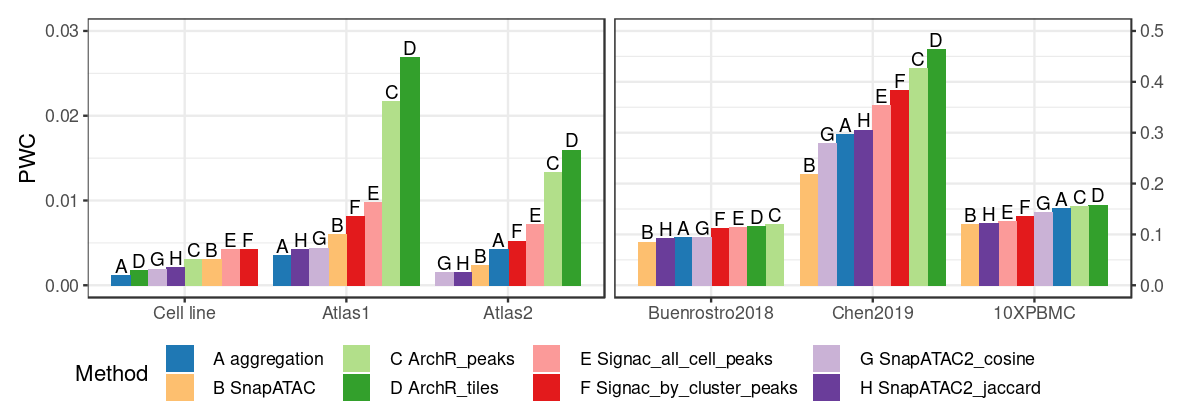

In [20]:
options(repr.plot.width=10, repr.plot.height=3.5)

p2.3.1 <- df_gs %>% 
        filter(dataset_type =="1") %>% 
        group_by(dataset_short) %>% 
        mutate(position = rank(average)) %>%
        ggplot(aes(x = dataset_short, y = average, fill = method, group = position)) +
        geom_bar(stat = "identity", position = "dodge") +
        labs(x="", y="PWC", fill="Method") +
      # ggtitle("Grouped Bar Plot") + 
        scale_fill_manual(values = my_col_m3) +
        ylim(0, 0.03) +
        theme_bw() +
        geom_col(position = "dodge") +
        geom_text(aes(label = method_short,vjust = ifelse(average > 0, -0.2, 1)), position = position_dodge(.9)) +
        theme(text = element_text(size = 13),legend.position = "none") #+ coord_cartesian(ylim = c(1, 2))

p2.3.2 <- df_gs %>% 
        filter(dataset_type =="2") %>% 
        group_by(dataset_short) %>% 
        mutate(position = rank(average)) %>%
        ggplot(aes(x = dataset_short, y = average, fill = method_name, group = position)) +
        geom_bar(stat = "identity", position = "dodge") +
        labs(x="", y="", fill="Method") +
      # ggtitle("Grouped Bar Plot") + 
        scale_fill_manual(values = my_col_m3) +
        theme_bw() +
        geom_col(position = "dodge") +
        geom_text(aes(label = method_short,vjust = ifelse(average > 0, -0.2, 1)), position = position_dodge(.9)) +
        theme(text = element_text(size = 13),
              legend.position = "bottom", 
              legend.justification = c(1.2,0), 
              legend.margin = margin(t = -15, r = 0, b = 0, l = 0, unit = "pt"),
              legend.spacing.x = unit(0.4, 'cm'),
              plot.margin = unit(c(0,0,0,0), "cm")) +
        scale_y_continuous(position = "right") + coord_cartesian(ylim = c(0, 0.5))

p2.3.3 <- p2.3.1 + p2.3.2 + theme(plot.margin = unit(c(0, 0, -1, 0), "cm"))
p2.3.3

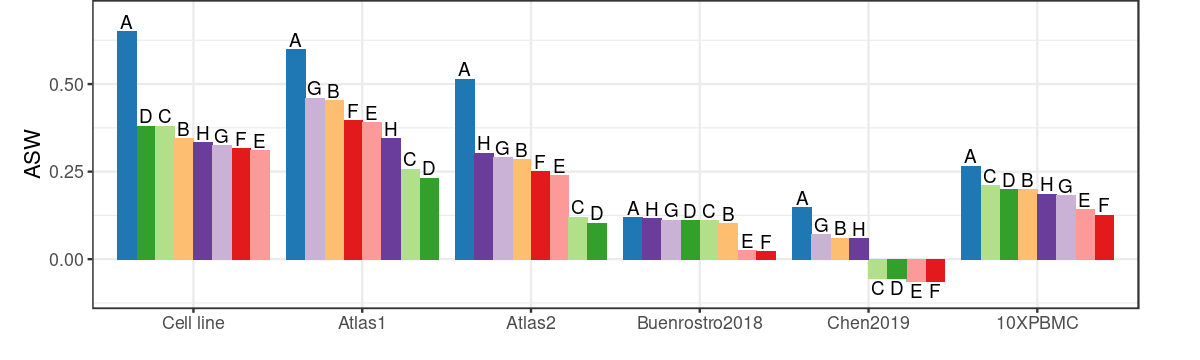

In [21]:
options(repr.plot.width=10, repr.plot.height=3)

p3.2 <- df_metrics_silhouette_s %>% 
        group_by(dataset) %>% 
        mutate(position = rank(-average)) %>%
        ggplot(aes(x = dataset, y = average, fill = long_method, group = position)) +
        geom_bar(stat = "identity", position = "dodge") +
        labs(x="", y="ASW", fill="Method") +
      # ggtitle("Grouped Bar Plot") + 
        scale_fill_manual(values = my_col_m3) +
        ylim(-0.1, 0.7) +
        theme_bw() +
        geom_col(position = "dodge") +
        geom_text(aes(label = method_short,vjust = ifelse(average > 0, -0.2, 1.2)), position = position_dodge(.9)) +
        theme(text = element_text(size = 13),legend.position = "none", plot.margin = unit(c(0,1.3,0,0.5), "cm")) #+ coord_cartesian(ylim = c(1, 2))

p3.2

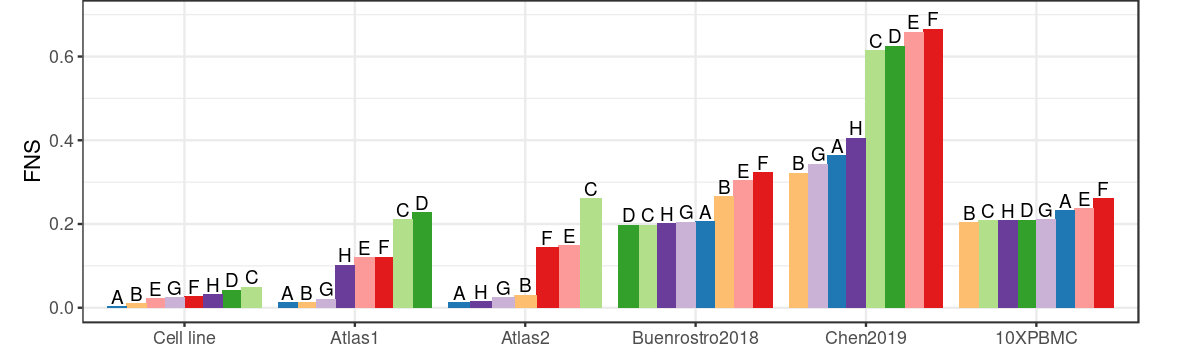

In [22]:
options(repr.plot.width=10, repr.plot.height=3)

p4.2 <- df_sil_frac %>% 
        group_by(dataset_short) %>% 
        mutate(position = rank(average)) %>%
        ggplot(aes(x = dataset_short, y = average, fill = long_method, group = position)) +
        geom_bar(stat = "identity", position = "dodge") +
        labs(x="", y="FNS", fill="Method") +
      # ggtitle("Grouped Bar Plot") + 
        scale_fill_manual(values = my_col_m3) +
        theme_bw() + 
        ylim(0, 0.7) + 
        geom_col(position = "dodge") +
        geom_text(aes(label = method_short,vjust = ifelse(average > 0, -0.2, 1)), position = position_dodge(.9)) +
        theme(text = element_text(size = 13),legend.position = "none", plot.margin = unit(c(0,1.3,-0.3,0.5), "cm")) #+ coord_cartesian(ylim = c(1, 2))

p4.2

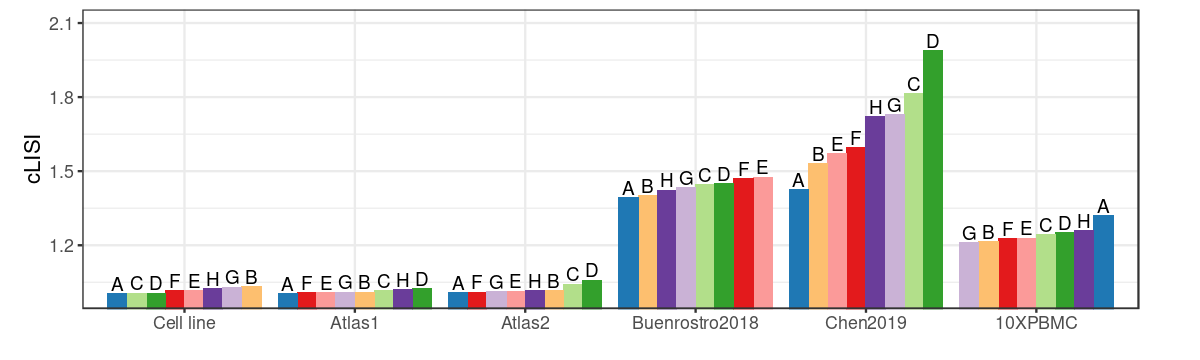

In [23]:
options(repr.plot.width=10, repr.plot.height=3)
p5.2 <- df_lisi_avg %>% 
        group_by(dataset) %>% 
        mutate(position = rank(average)) %>%
        ggplot(aes(x = dataset, y = average, fill = method_name, group = position)) +
        geom_bar(stat = "identity", position = "dodge") +
        labs(x="", y="cLISI", fill="Method") +
      # ggtitle("Grouped Bar Plot") + 
        scale_fill_manual(values = my_col_m3) +
        theme_bw() +
        geom_col(position = "dodge") +
        geom_text(aes(label = method_short,vjust = ifelse(average > 0, -0.2, 1)), position = position_dodge(.9)) +
        
        theme(text = element_text(size = 13),legend.position = "none", plot.margin = unit(c(0.2,1.3,0,0.5), "cm")) + 
        coord_cartesian(ylim = c(1, 2.1))

p5.2

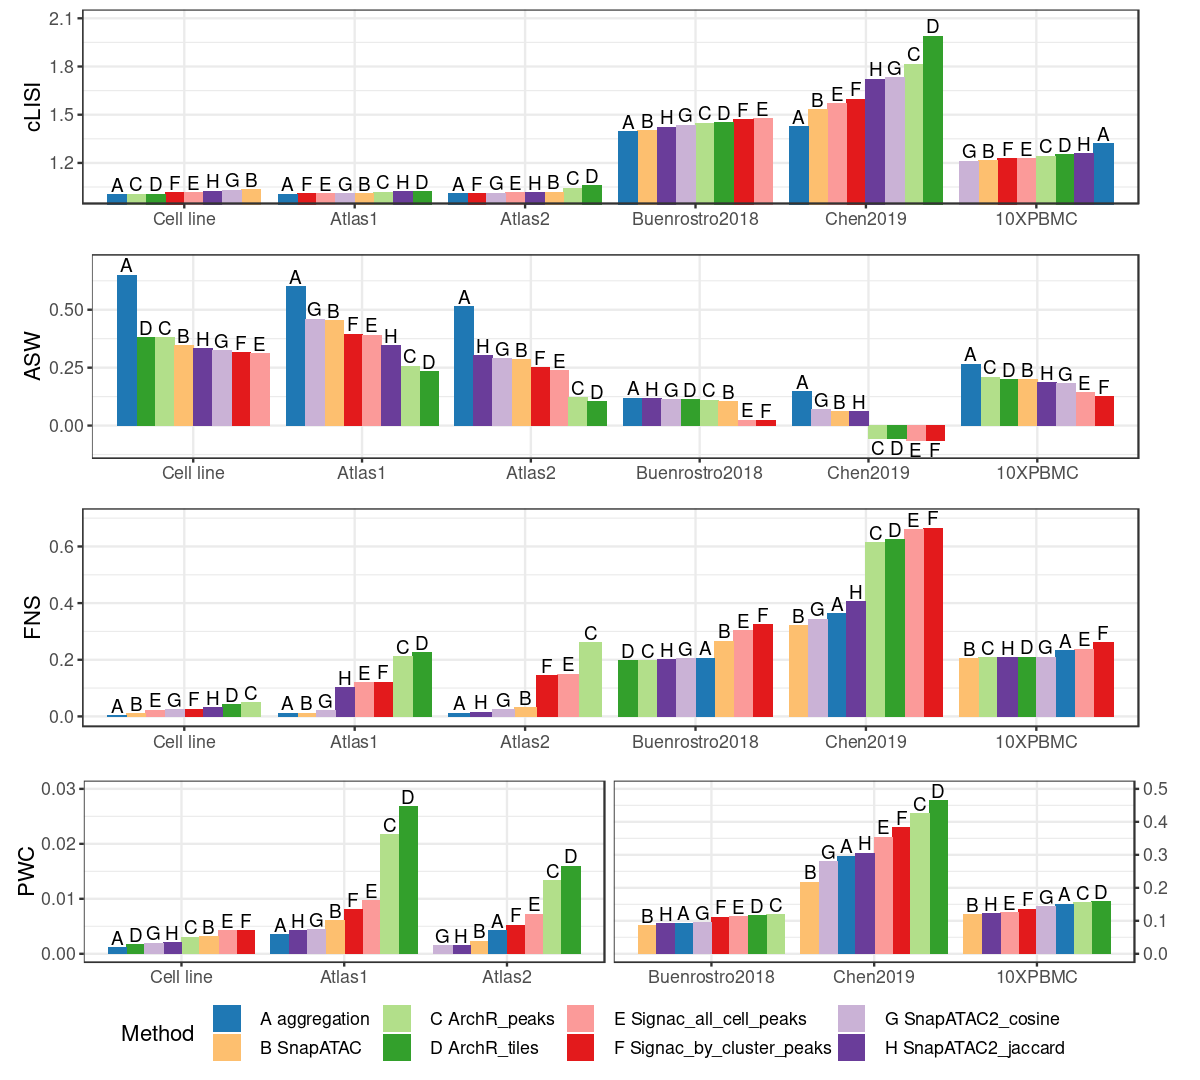

In [24]:
options(repr.plot.width=10, repr.plot.height=9)
p6 <- ggarrange(p5.2, p3.2, p4.2, p2.3.3, nrow = 4, ncol = 1, heights = c(4,4,4,5)) 
p6

In [196]:
pdf("Fig2.pdf", width=10, height=9)
plot(p6)
dev.off() 

png 
  2

# Fig 3: ARI

In [25]:
df_metrics_ari <- df_metrics %>% filter(metric == "ARI") %>% filter(ndim == 15)

In [26]:
vline_data <- data.frame(dataset = c("Cell line","Atlas1", "Atlas2","Buenrostro2018","Chen2019","10XPBMC"), vline_x = k_ls)
vline_data$dataset <- factor(vline_data$dataset, levels = c("Cell line","Atlas1", "Atlas2","Buenrostro2018","Chen2019","10XPBMC"))

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


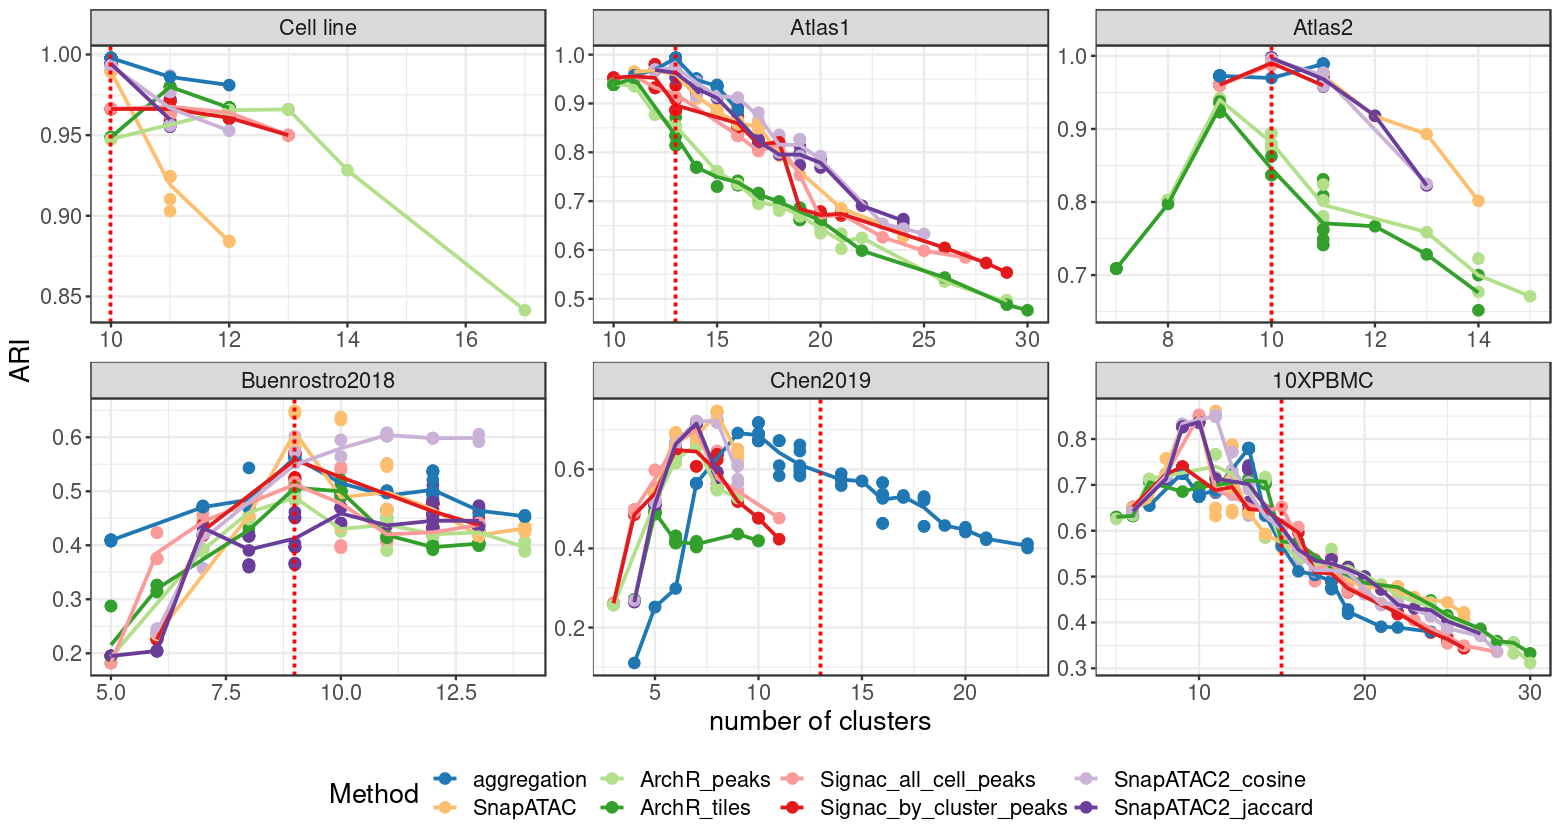

In [27]:
# ARI
options(repr.plot.width=13, repr.plot.height=7)

p1 <-
df_metrics_ari %>% 
  group_by(dataset, long_method, n_clusters) %>%
  mutate(mean_value = mean(value)) %>%
  ggplot(aes(x=n_clusters, y=value, color=long_method)) + 
  geom_point(size=2.5) +
  geom_line(size=0.8, aes(x=n_clusters, y=mean_value, color=long_method)) + 
  facet_wrap(~dataset, scales = "free", nrow = 2, ncol = 3) + 
  geom_vline(data = vline_data, aes(xintercept = vline_x), linetype = "dashed", color = "red", size=0.8) + 
  xlab("number of clusters") +
  ylab("ARI") +
  labs(color="Method") +
  theme_bw() +
  theme(text = element_text(size = 16),legend.position = "bottom") +
  scale_colour_manual(values = my_col_m3)
p1

In [77]:
pdf("Fig3a.pdf", width=13, height=7)
plot(p1)
dev.off() 

png 
  2

# Fig S1: ARI2

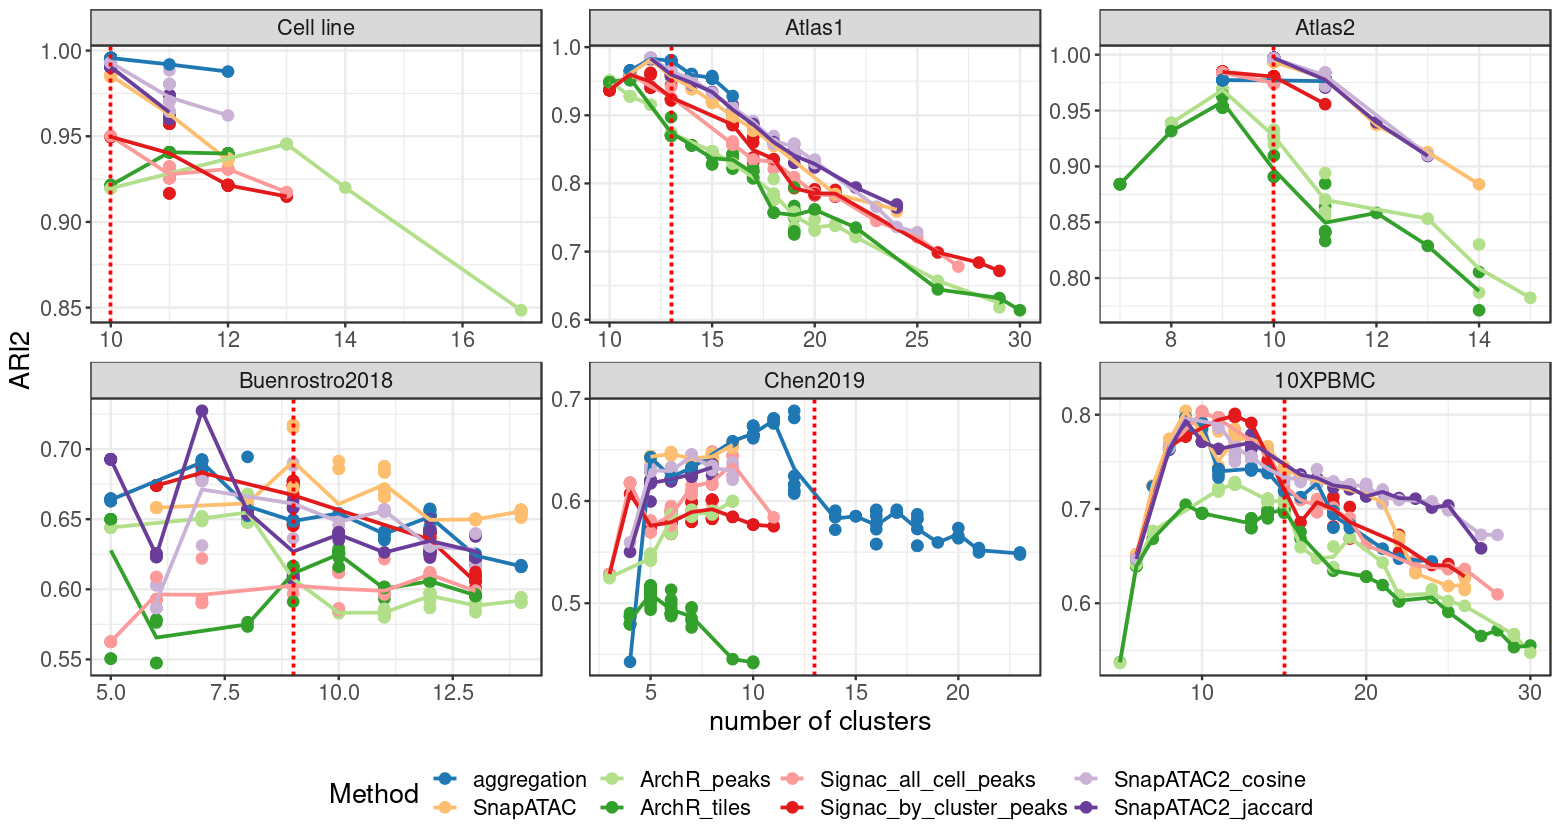

In [28]:
options(repr.plot.width=13, repr.plot.height=7)

df_metrics_ari2 <- df_metrics %>% filter(metric == "ARI2") %>% filter(ndim == 15)

p2 <-
df_metrics_ari2 %>% 
  group_by(dataset, long_method, n_clusters) %>%
  mutate(mean_value = mean(value)) %>%
  ggplot(aes(x=n_clusters, y=value, color=long_method)) + 
  geom_point(size=2.5) +
  geom_line(size=0.8, aes(x=n_clusters, y=mean_value, color=long_method)) + 
  facet_wrap(~dataset, scales = "free", nrow = 2, ncol = 3) + 
  geom_vline(data = vline_data, aes(xintercept = vline_x), linetype = "dashed", color = "red", size=0.8) + 
  xlab("number of clusters") +
  ylab("ARI2") +
  labs(color="Method") +
  theme_bw() +
  theme(text = element_text(size = 16),legend.position = "bottom") +
  scale_colour_manual(values = my_col_m3)
p2

In [78]:
pdf("FigS1a.pdf", width=13, height=7)
plot(p2)
dev.off() 

png 
  2

# Fig S5

In [29]:
df_lisi_avg$metric <- "cLISI"
df_gs$metric <- "PWC"
df_sil_frac$metric <- "FNS"
df_sil_frac$method_name <- as.character(df_sil_frac$method_name)
df_sil_frac$method_short <- as.character(df_sil_frac$method_short)

df_lisi_avg <- df_lisi_avg[,c("long_method", "dataset", "average", "method_name", "method_short", "metric")]
df_gs <- df_gs[,c("method", "dataset_short", "average", "method_name", "method_short", "metric")]
df_sil_frac <- df_sil_frac[,c("long_method", "dataset_short", "average", "method_name", "method_short", "metric")]

names(df_gs)[names(df_gs)=="method"] <- "long_method"
names(df_gs)[names(df_gs)=="dataset_short"] <- "dataset"
names(df_sil_frac)[names(df_sil_frac)=="dataset_short"] <- "dataset"

In [30]:
head(df_lisi_avg)
head(df_gs)
head(df_sil_frac)

long_method,dataset,average,method_name,method_short,metric
<fct>,<fct>,<dbl>,<chr>,<chr>,<chr>
Signac_by_cluster_peaks,Cell line,1.014761,F Signac_by_cluster_peaks,F,cLISI
Signac_all_cell_peaks,Cell line,1.015117,E Signac_all_cell_peaks,E,cLISI
ArchR_tiles,Cell line,1.005888,D ArchR_tiles,D,cLISI
ArchR_peaks,Cell line,1.005708,C ArchR_peaks,C,cLISI
SnapATAC,Cell line,1.031597,B SnapATAC,B,cLISI
aggregation,Cell line,1.003258,A aggregation,A,cLISI


long_method,dataset,average,method_name,method_short,metric
<fct>,<fct>,<dbl>,<chr>,<chr>,<chr>
Signac_by_cluster_peaks,Cell line,0.004244095,F Signac_by_cluster_peaks,F,PWC
Signac_all_cell_peaks,Cell line,0.004163120,E Signac_all_cell_peaks,E,PWC
ArchR_tiles,Cell line,0.001719935,D ArchR_tiles,D,PWC
ArchR_peaks,Cell line,0.003004065,C ArchR_peaks,C,PWC
SnapATAC,Cell line,0.003063441,B SnapATAC,B,PWC
aggregation,Cell line,0.001146118,A aggregation,A,PWC


long_method,dataset,average,method_name,method_short,metric
<fct>,<fct>,<dbl>,<chr>,<chr>,<chr>
Signac_by_cluster_peaks,Cell line,0.025694690,F Signac_by_cluster_peaks,F,FNS
Signac_all_cell_peaks,Cell line,0.021946829,E Signac_all_cell_peaks,E,FNS
ArchR_tiles,Cell line,0.042045451,D ArchR_tiles,D,FNS
ArchR_peaks,Cell line,0.049399456,C ArchR_peaks,C,FNS
SnapATAC,Cell line,0.010093875,B SnapATAC,B,FNS
aggregation,Cell line,0.002173432,A aggregation,A,FNS


In [31]:
df_compare <- rbind(df_lisi_avg, df_sil_frac, df_gs)

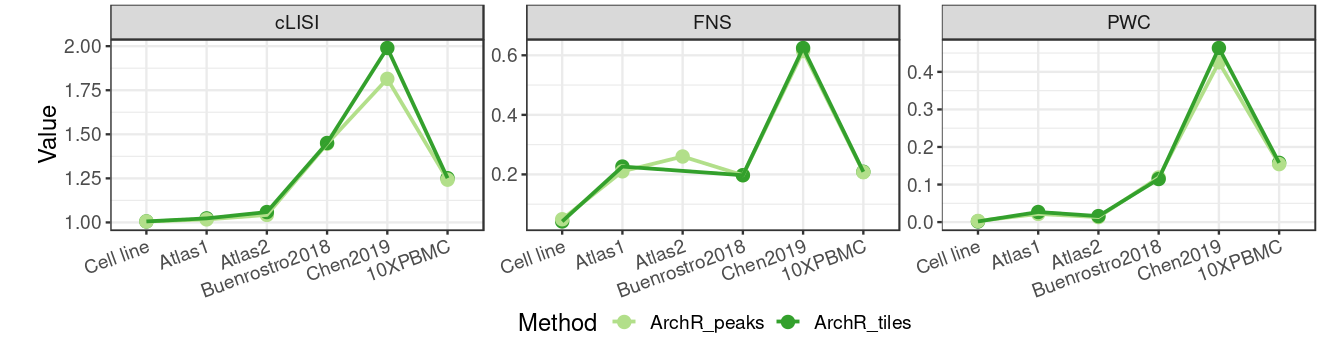

In [32]:
options(repr.plot.width=11, repr.plot.height=3)

p1 <-
df_compare %>% filter(long_method %in% c("ArchR_tiles", "ArchR_peaks")) %>%
  ggplot(aes(x=dataset, y=average, color=long_method)) + 
  geom_point(size=3) +
  geom_line(size=0.8, aes(x=dataset, y=average, group=long_method)) + 
  facet_wrap(~metric, scales = "free", nrow = 1, ncol = 3) + 
  xlab("") +
  ylab("Value") +
  labs(color="Method") +
  theme_bw() +
  theme(text = element_text(size = 14),
  legend.position = "bottom", 
  # legend.justification = c(1.2,0), 
  legend.margin = margin(t = -25, r = 0, b = 0, l = 0, unit = "pt"),
  # legend.spacing.x = unit(0.4, 'cm'),
  plot.margin = unit(c(0.1,0.1,0.5,0.8), "cm"),
  axis.text.x = element_text(angle = 20, hjust=1)) +
  scale_colour_manual(values = my_col_m3[c(3,4)]) #+ ylim(0, 0.8)
p1

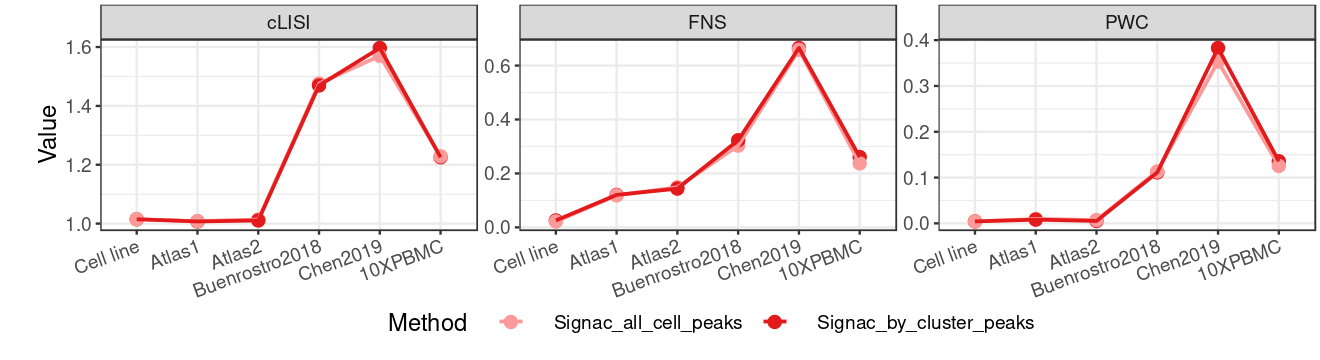

In [33]:
options(repr.plot.width=11, repr.plot.height=3)

p2 <-
df_compare %>% filter(long_method %in% c("Signac_all_cell_peaks", "Signac_by_cluster_peaks")) %>%
  ggplot(aes(x=dataset, y=average, color=long_method)) + 
  geom_point(size=3) +
  geom_line(size=0.8, aes(x=dataset, y=average, group=long_method)) + 
  facet_wrap(~metric, scales = "free", nrow = 1, ncol = 3) + 
  xlab("") +
  ylab("Value") +
  labs(color="Method") +
  theme_bw() +
  theme(text = element_text(size = 14),
  legend.position = "bottom", 
  # legend.justification = c(1.2,0), 
  legend.margin = margin(t = -25, r = 0, b = 0, l = 0, unit = "pt"),
  legend.spacing.x = unit(0.6, 'cm'),
  plot.margin = unit(c(0.1,0.1,0.5,0.8), "cm"),
  axis.text.x = element_text(angle = 20, hjust=1)) +
  scale_colour_manual(values = my_col_m3[c(5,6)]) #+ ylim(0, 0.8)
p2

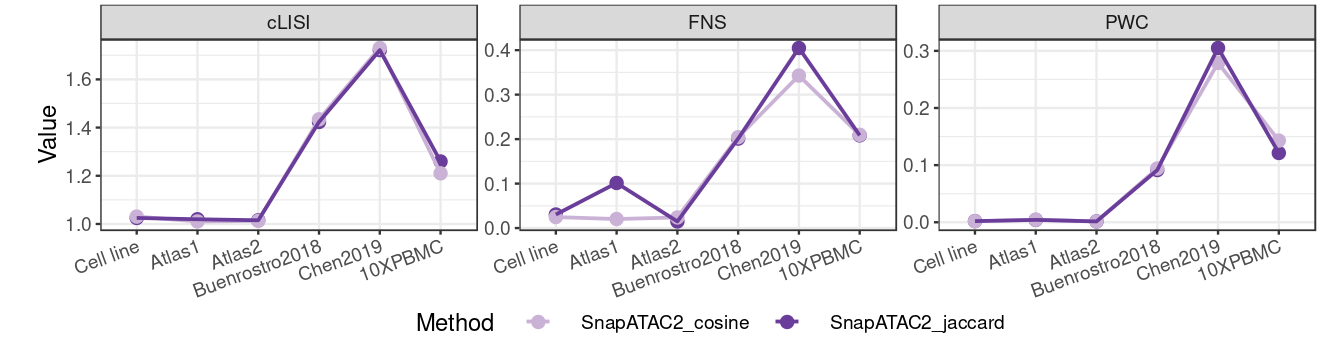

In [34]:
options(repr.plot.width=11, repr.plot.height=3)

p3 <-
df_compare %>% filter(long_method %in% c("SnapATAC2_jaccard", "SnapATAC2_cosine")) %>%
  ggplot(aes(x=dataset, y=average, color=long_method)) + 
  geom_point(size=3) +
  geom_line(size=0.8, aes(x=dataset, y=average, group=long_method)) + 
  facet_wrap(~metric, scales = "free", nrow = 1, ncol = 3) + 
  xlab("") +
  ylab("Value") +
  labs(color="Method") +
  theme_bw() +
  theme(text = element_text(size = 14),
  legend.position = "bottom", 
  # legend.justification = c(1.2,0), 
  legend.margin = margin(t = -25, r = 0, b = 0, l = 0, unit = "pt"),
  legend.spacing.x = unit(0.6, 'cm'),
  plot.margin = unit(c(0.1,0.1,0.5,0.8), "cm"),
  axis.text.x = element_text(angle = 20, hjust=1)) +
  scale_colour_manual(values = my_col_m3[c(7,8)]) #+ ylim(0, 0.8)
p3

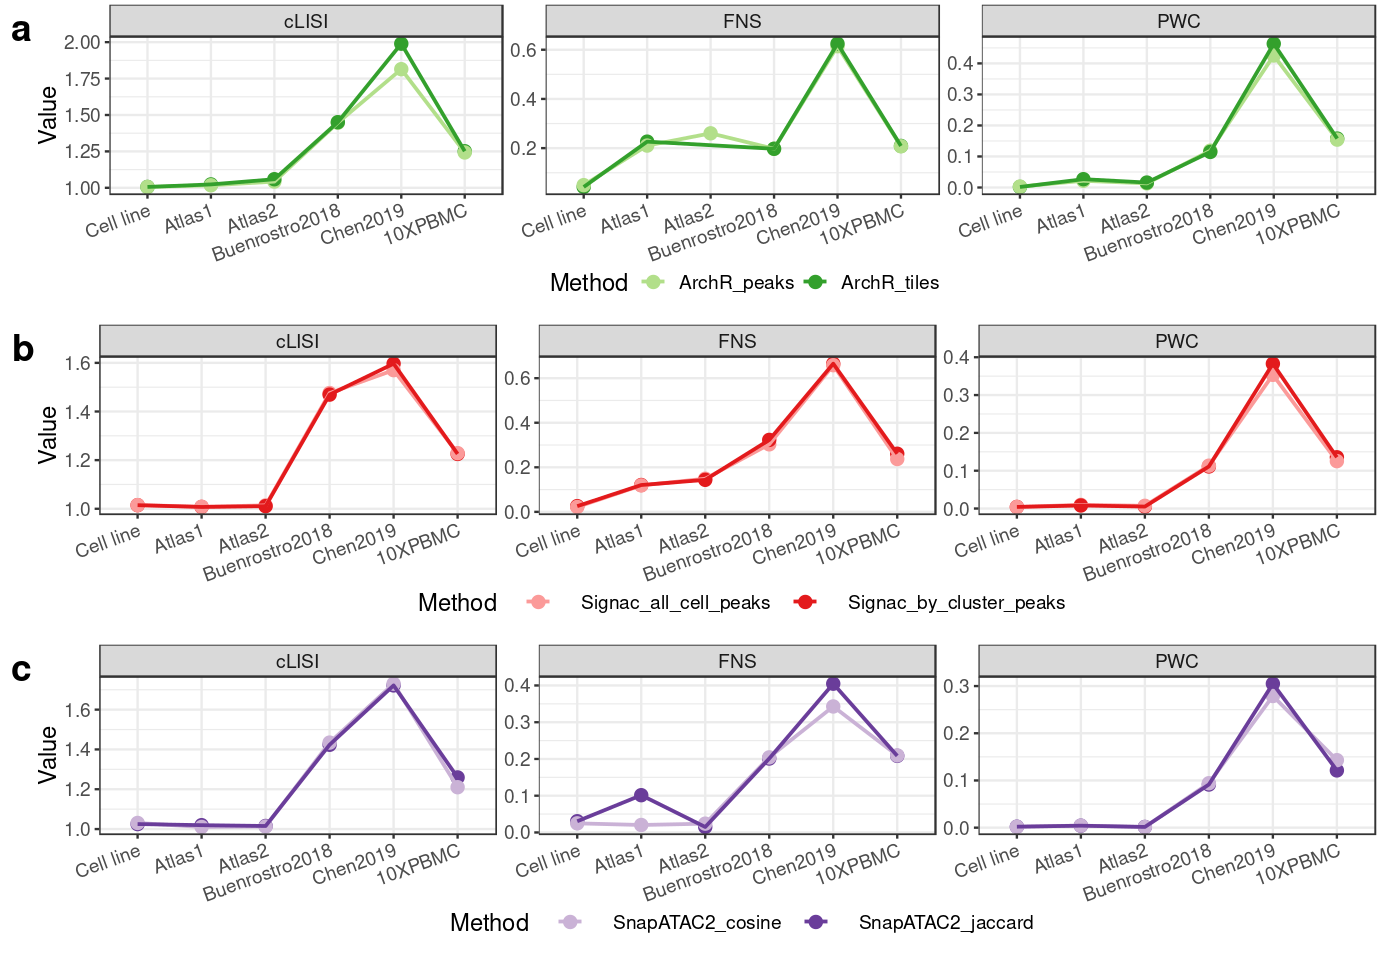

In [35]:
library(ggpubr)
options(repr.plot.width=11.5, repr.plot.height=8)
p4 <- ggarrange(p1, p2, p3, 
          labels = c("a", "b", "c"),font.label=list(color="black",size=22, face="bold"),
          ncol = 1, nrow = 3)
p4


In [229]:
pdf(paste0("Fig S5.pdf"), width=11.5, height=8)
print(p4)
dev.off() 

png 
  2

# Fig 3b: AUC

## Calculating AUC

In [36]:
library(pracma)


Attaching package: ‘pracma’


The following object is masked from ‘package:MESS’:

    repmat




In [37]:
df_metrics_selected <- df_metrics %>% filter(ndim==15) %>% filter(metric %in% c("ARI", "ARI2","AMI", "AV", "AW", "MI", "VI"))
dim(df_metrics_selected)

[1] 19649    17

In [38]:
df_metrics_filtered <- df_metrics_selected %>% group_by(dataset, long_method, metric) %>%
  # filter(value != min(value)) %>%
  group_by(dataset, long_method, n_clusters, metric) %>%
  mutate(mean_value = mean(value)) %>%
  ungroup() 

df_metrics_filtered <- df_metrics_filtered[!duplicated(subset(df_metrics_filtered, select = c(n_clusters,metric,long_method, dataset))), ]

dim(df_metrics_filtered)

[1] 2905   18

In [39]:
df_metrics_filtered <- df_metrics_filtered %>% 
    group_by(dataset, metric) %>%
  mutate(upper_bound = max(mean_value)) %>%
  ungroup() 
df_metrics_filtered$upper_bound[!df_metrics_filtered$metric %in% c("MI", "VI")] <- 1


In [40]:
df_auc <- df_metrics_filtered[order(df_metrics_filtered$long_method, df_metrics_filtered$dataset, df_metrics_filtered$metric, df_metrics_filtered$n_clusters),] %>% 
    group_by(dataset, long_method, metric) %>% 
    mutate(auc=trapz(n_clusters, mean_value), total_area=trapz(n_clusters, upper_bound)) %>% 
    mutate(auc_frac=auc/total_area)
df_auc <- df_auc[!duplicated(subset(df_auc, select = c(metric, long_method, dataset))), ]

df_auc$auc_frac[df_auc$metric=="VI"] <- 1-df_auc$auc_frac[df_auc$metric=="VI"]
dim(df_auc)
head(df_auc)

[1] 336  22

n_clusters,metric,value,method,long_method,feature_type,tile_size,distance,ndim,resolution,⋯,snn_file,seed,dataset,k_optimal,dataset2,mean_value,upper_bound,auc,total_area,auc_frac
<int>,<chr>,<dbl>,<chr>,<fct>,<chr>,<int>,<chr>,<int>,<dbl>,⋯,<chr>,<int>,<fct>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10,AMI,0.9953377,aggregation,aggregation,default,500,default,15,0.05,⋯,Cell_line_mixing/clustering/aggregation/default/500/default/15/sobj_SNN.RDS,0,Cell line,10,Cell_line_mixing,0.9953377,1.000000,1.966108,2.000000,0.9830542
10,ARI,0.9977881,aggregation,aggregation,default,500,default,15,0.05,⋯,Cell_line_mixing/clustering/aggregation/default/500/default/15/sobj_SNN.RDS,0,Cell line,10,Cell_line_mixing,0.9977881,1.000000,1.975438,2.000000,0.9877191
10,ARI2,0.9956534,aggregation,aggregation,default,500,default,15,0.05,⋯,Cell_line_mixing/clustering/aggregation/default/500/default/15/sobj_SNN.RDS,0,Cell line,10,Cell_line_mixing,0.9956534,1.000000,1.983580,2.000000,0.9917899
10,AV,0.9982032,aggregation,aggregation,default,500,default,15,0.05,⋯,Cell_line_mixing/clustering/aggregation/default/500/default/15/sobj_SNN.RDS,0,Cell line,10,Cell_line_mixing,0.9982032,1.000000,1.996414,2.000000,0.9982069
10,AW,0.9973734,aggregation,aggregation,default,500,default,15,0.05,⋯,Cell_line_mixing/clustering/aggregation/default/500/default/15/sobj_SNN.RDS,0,Cell line,10,Cell_line_mixing,0.9973734,1.000000,1.955048,2.000000,0.9775241
10,MI,2.1421204,aggregation,aggregation,default,500,default,15,0.05,⋯,Cell_line_mixing/clustering/aggregation/default/500/default/15/sobj_SNN.RDS,0,Cell line,10,Cell_line_mixing,2.1421204,2.142314,4.284338,4.284629,0.9999320


In [41]:
df_auc$dataset <- factor(df_auc$dataset, levels = dataset_name)

## MAD scaling

In [42]:
library(ComplexHeatmap)
library(circlize)

Loading required package: grid



ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualizati

In [43]:
colCenterScale <- function(x, centerFn=median, 
                           scaleFn=function(x,na.rm) median(abs(x),na.rm=na.rm)
                           ){
  if(is.null(dim(x))) stop("`x` should be a numeric matrix or data.frame.")
  centers <- apply(x, MARGIN=2, na.rm=TRUE, FUN=centerFn)
  x2 <- t(t(x)-centers)
  x2 <- x2/scaleFn(x2, na.rm=TRUE)    # why this denominator???
  if(all(is.na(x2))) x2[is.na(x2)] <- 0
  x2
}

In [44]:
hm_metric <- function(df_auc, col_ls, col_fun, name, col_title){
    df_pl <- df_auc[,c("metric", "long_method", "auc_frac", 'dataset')]
    df_wide <- pivot_wider(df_pl, names_from = dataset, values_from = auc_frac)
    long_method_vec <- as.character(df_wide$long_method)
    df_wide <- df_wide[,c("Cell line", "Atlas1", "Atlas2", "Buenrostro2018", "Chen2019", "10XPBMC")]
    df_wide2 <- df_wide
    df_wide <- as.data.frame(colCenterScale(df_wide))
    rownames(df_wide) <- long_method_vec
    maxv <- max(abs(df_wide[!is.na(df_wide)]))
    # col_fun <- colorRamp2(c(-maxv,-maxv/2, 0, maxv/2, maxv), c("green", "#66FF66", "white", "#FF6666", "red"))

    column_ha = HeatmapAnnotation(dataset=c("Cell line", "Atlas1", "Atlas2", "Buenrostro2018", "Chen2019", "10XPBMC"), 
                                  col = list(dataset= col_ls),  
                                  show_annotation_name = FALSE,
                                  annotation_legend_param = list(dataset = list(
                                ncol = 1, 
                                # nrow = 1, 
                                title = "Datasets", 
                                # title_position = "topcenter",
                                # title_position = "leftcenter",
                                at = c("Cell line", "Atlas1", "Atlas2", "Buenrostro2018", "Chen2019", "10XPBMC"))))
                                # labels = c("Cell line", "Atlas1", "Atlas2", "Buenrostro2018", "Chen2019", "10XPBMC"))),
                                # column_order = c("Cell line", "Atlas1", "Atlas2", "Buenrostro2018", "Chen2019", "10XPBMC"))
    ht <- Heatmap(df_wide, 
    name = name, 
    col = col_fun, 
    cluster_rows = FALSE, 
    cluster_columns = FALSE, 
    column_title = col_title,
    rect_gp = gpar(col = "white", lwd = 2), 
    bottom_annotation = column_ha, show_column_names = FALSE,
    heatmap_legend_param = list(title = "MADs", at=c(-maxv, 0, maxv), labels=c("worst","median","best")), 
    show_heatmap_legend = FALSE, border = TRUE,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%.2f", df_wide2[i, j]), x, y, gp = gpar(fontsize = 10))},
    # column_order = c(6,2,3,4,1,5)
    column_order = c("Cell line", "Atlas1", "Atlas2", "Buenrostro2018", "Chen2019", "10XPBMC"),
    row_order = c("aggregation", "SnapATAC2_cosine", "SnapATAC2_jaccard", "SnapATAC", "Signac_by_cluster_peaks", "Signac_all_cell_peaks", "ArchR_peaks", "ArchR_tiles")
    )

    return(list(ht=ht, maxv=maxv))
}

In [45]:
my_col_c <- my_col_d
names(my_col_c) <- NULL
col_ls <- c('Cell line' = my_col_c[1],
'Atlas1' = my_col_c[2],
'Atlas2' = my_col_c[3],
'Buenrostro2018' = my_col_c[4],
'Chen2019' = my_col_c[5],
'10XPBMC' = my_col_c[6])

In [46]:
maxv <- 18
col_fun = colorRamp2(c(-maxv, -maxv/2, 0, maxv/2, maxv), c("green", "#66FF66", "white", "#FF6666", "red"))
col_fun = colorRamp2(c(-maxv, -maxv/2, 0, maxv/2, maxv), c("blue", "#3333FF", "white", "#FF3333", "red"))

df_auc_sub <- df_auc %>% filter(metric == "ARI")
res <- hm_metric(df_auc_sub, col_ls, col_fun, "ari", "ARI")
hm_ari <- res$ht
maxv <- res$maxv

df_auc_sub <- df_auc %>% filter(metric == "ARI2")
res <- hm_metric(df_auc_sub, col_ls, col_fun, "ari2", "ARI2")
hm_ari2 <- res$ht
maxv <- max(c(maxv, res$maxv))

df_auc_sub <- df_auc %>% filter(metric == "AMI")
res <- hm_metric(df_auc_sub, col_ls, col_fun, "ami", "AMI")
hm_ami <- res$ht
maxv <- max(c(maxv, res$maxv))

df_auc_sub <- df_auc %>% filter(metric == "AV")
res <- hm_metric(df_auc_sub, col_ls, col_fun, "av", "AV")
hm_av <- res$ht
maxv <- max(c(maxv, res$maxv))

df_auc_sub <- df_auc %>% filter(metric == "AW")
res <- hm_metric(df_auc_sub, col_ls, col_fun, "aw", "AW")
hm_aw <- res$ht
maxv <- max(c(maxv, res$maxv))

df_auc_sub <- df_auc %>% filter(metric == "MI")
res <- hm_metric(df_auc_sub, col_ls, col_fun, "mi", "MI")
hm_mi <- res$ht
maxv <- max(c(maxv, res$maxv))

df_auc_sub <- df_auc %>% filter(metric == "VI")
res <- hm_metric(df_auc_sub, col_ls, col_fun, "vi", "VI")
hm_vi <- res$ht
maxv <- max(c(maxv, res$maxv))

Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”


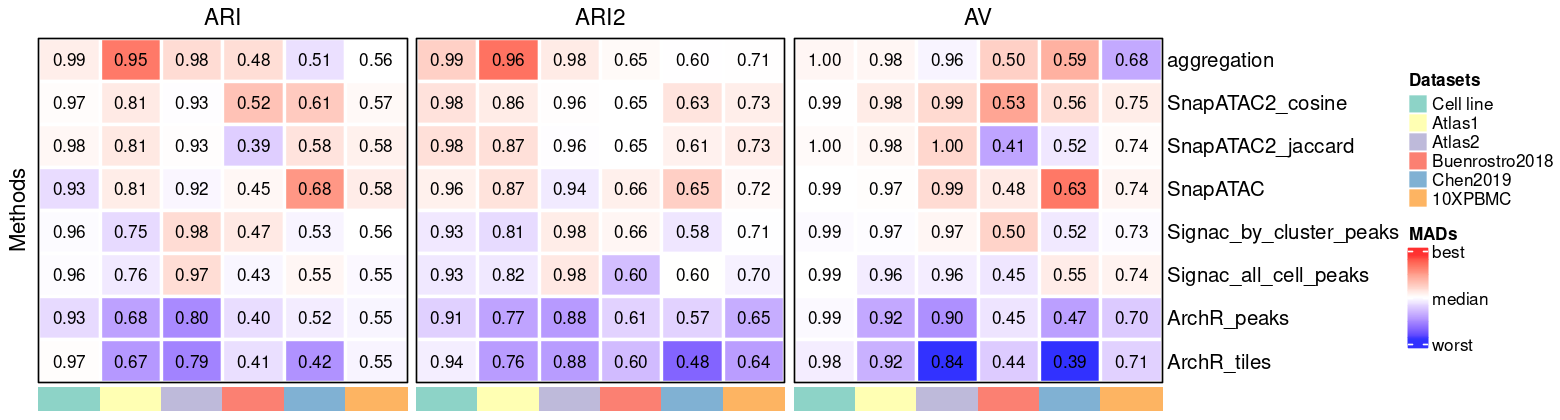

In [47]:
options(repr.plot.width=13, repr.plot.height=3.5)
ht_list1 = hm_ari + hm_ari2 + hm_av #+ hm_aw + hm_mi + hm_vi #+ hm_ami
# maxv <- 14

draw(ht_list1, row_title = "Methods",
    column_title_gp = gpar(fontsize = 16), 
    annotation_legend_list= ComplexHeatmap::Legend(col_fun=col_fun, title = "MADs", at=c(-maxv, 0, maxv), labels=c("worst","median","best")))

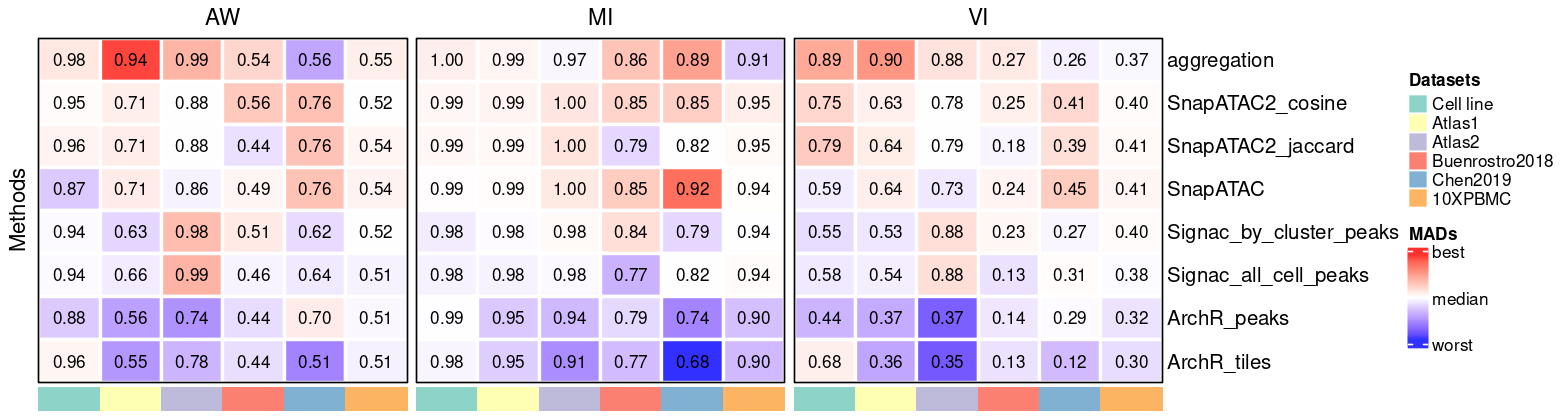

In [48]:
ht_list2 = hm_aw + hm_mi + hm_vi #+ hm_ami

draw(ht_list2, row_title = "Methods",
    column_title_gp = gpar(fontsize = 16), 
    annotation_legend_list= ComplexHeatmap::Legend(col_fun=col_fun, title = "MADs", at=c(-maxv, 0, maxv), labels=c("worst","median","best")))

In [253]:
ht_list = hm_ari + hm_ari2 + hm_av
# ht_list = hm_aw + hm_mi + hm_vi

pdf(paste0("/home/siluo/public/SiyuanLuo/projects/benchmark/scripts/analysis/visualization/Fig3b1.pdf"), width=13, height=3)
draw(ht_list, row_title = "Methods",
    column_title_gp = gpar(fontsize = 16), 
    annotation_legend_list= ComplexHeatmap::Legend(col_fun=col_fun, title = "MADs", at=c(-maxv, 0, maxv), labels=c("worst","median","best")))
dev.off() 

png 
  2

In [254]:
ht_list = hm_aw + hm_mi + hm_vi

pdf(paste0("/home/siluo/public/SiyuanLuo/projects/benchmark/scripts/analysis/visualization/Fig3b2.pdf"), width=13, height=3)
draw(ht_list, row_title = "Methods",
    column_title_gp = gpar(fontsize = 16), 
    annotation_legend_list= ComplexHeatmap::Legend(col_fun=col_fun, title = "MADs", at=c(-maxv, 0, maxv), labels=c("worst","median","best")))
dev.off() 

png 
  2

# Fig S6

In [49]:
df_auc_tmp <- df_auc %>% filter(long_method %in% c("ArchR_tiles", "ArchR_peaks","Signac_all_cell_peaks", "Signac_by_cluster_peaks", "SnapATAC2_cosine", "SnapATAC2_jaccard"))
df_auc_tmp <- df_auc_tmp %>% filter(metric !="AMI")

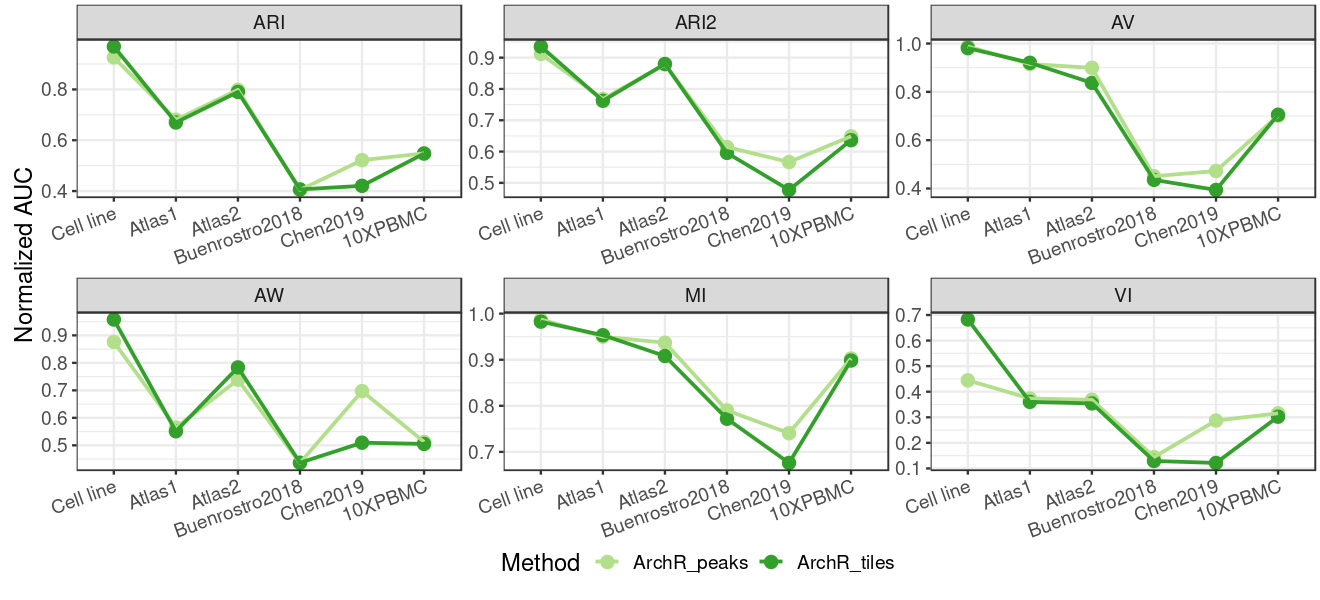

In [50]:
options(repr.plot.width=11, repr.plot.height=5)

p1 <-
df_auc_tmp %>% filter(long_method %in% c("ArchR_tiles", "ArchR_peaks")) %>%
  ggplot(aes(x=dataset, y=auc_frac, color=long_method)) + 
  geom_point(size=3) +
  geom_line(size=0.8, aes(x=dataset, y=auc_frac, group=long_method)) + 
  facet_wrap(~metric, scales = "free", nrow = 2, ncol = 3) + 
  xlab("") +
  ylab("Normalized AUC") +
  labs(color="Method") +
  theme_bw() +
  theme(text = element_text(size = 14),
  legend.position = "bottom", 
  legend.margin = margin(t = -25, r = 0, b = 0, l = 0, unit = "pt"),
  plot.margin = unit(c(0.1,0.1,0.5,0.3), "cm"),
  axis.text.x = element_text(angle = 20, hjust=1)) +
  scale_colour_manual(values = my_col_m3[c(3,4)]) 
p1

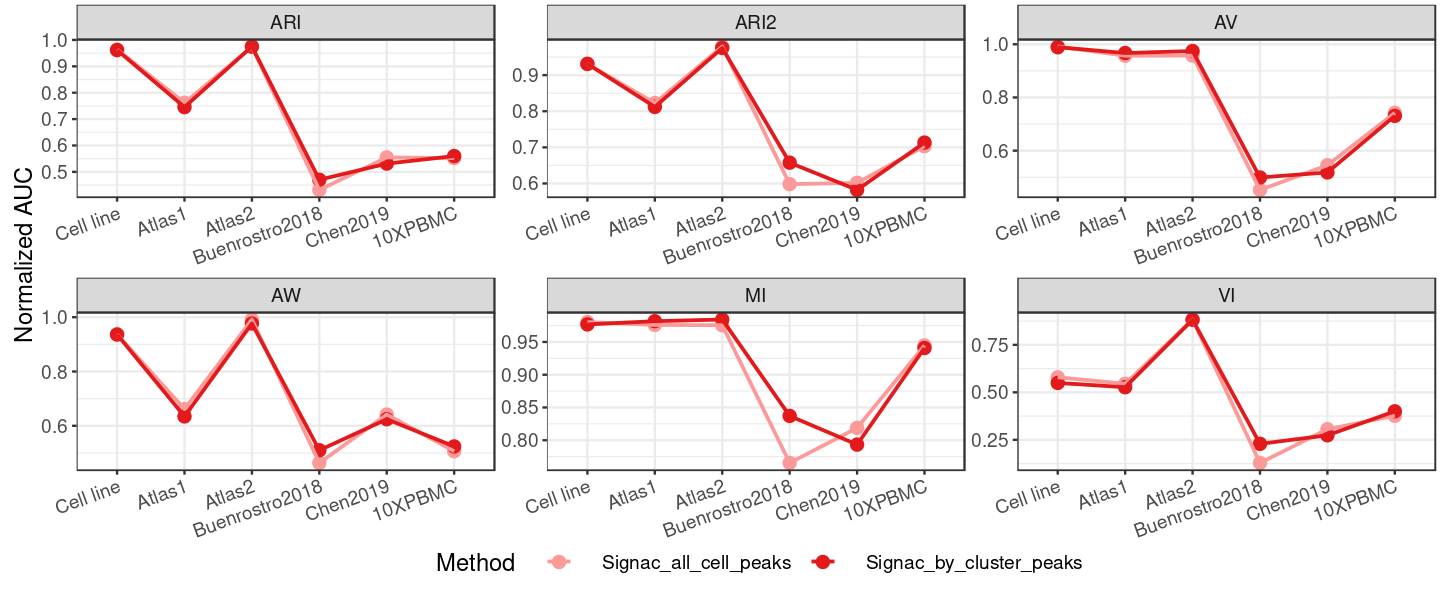

In [51]:
options(repr.plot.width=12, repr.plot.height=5)

p2 <-
df_auc_tmp %>% filter(long_method %in% c("Signac_all_cell_peaks", "Signac_by_cluster_peaks")) %>%
  ggplot(aes(x=dataset, y=	auc_frac, color=long_method)) + 
  geom_point(size=3) +
  geom_line(size=0.8, aes(x=dataset, y=auc_frac, group=long_method)) + 
  facet_wrap(~metric, scales = "free", nrow = 2, ncol = 3) + 
  xlab("") +
  ylab("Normalized AUC") +
  labs(color="Method") +
  theme_bw() +
  theme(text = element_text(size = 14),
        legend.position = "bottom",
        legend.margin = margin(t = -25, r = 0, b = 0, l = 0, unit = "pt"),
        plot.margin = unit(c(0.1,0.1,0.5,0.3), "cm"), 
        axis.text.x = element_text(angle = 20, hjust=1),
        legend.spacing.x = unit(0.6, 'cm')) +
  scale_colour_manual(values = my_col_m3[c(5,6)]) 
p2

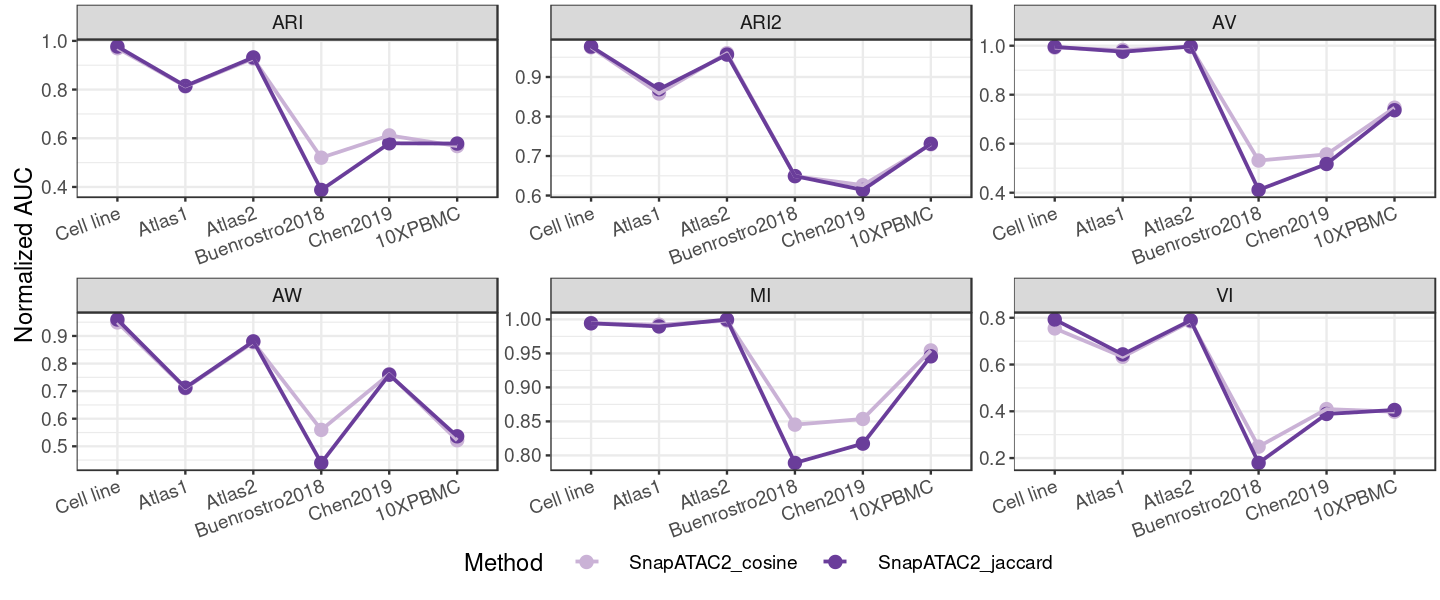

In [52]:
options(repr.plot.width=12, repr.plot.height=5)

p3 <-
df_auc_tmp %>% filter(long_method %in% c("SnapATAC2_cosine", "SnapATAC2_jaccard")) %>%
  ggplot(aes(x=dataset, y=	auc_frac, color=long_method)) + 
  geom_point(size=3) +
  geom_line(size=0.8, aes(x=dataset, y=auc_frac, group=long_method)) + 
  facet_wrap(~metric, scales = "free", nrow = 2, ncol = 3) + 
  xlab("") +
  ylab("Normalized AUC") +
  labs(color="Method") +
  theme_bw() +
  theme(text = element_text(size = 14),
        legend.position = "bottom", 
        legend.margin = margin(t = -25, r = 0, b = 0, l = 0, unit = "pt"),
        legend.spacing.x = unit(0.6, 'cm'),
        plot.margin = unit(c(0.1,0.1,0.5,0.3), "cm"),
        axis.text.x = element_text(angle = 20, hjust=1)) +
  scale_colour_manual(values = my_col_m3[c(7,8)])
p3

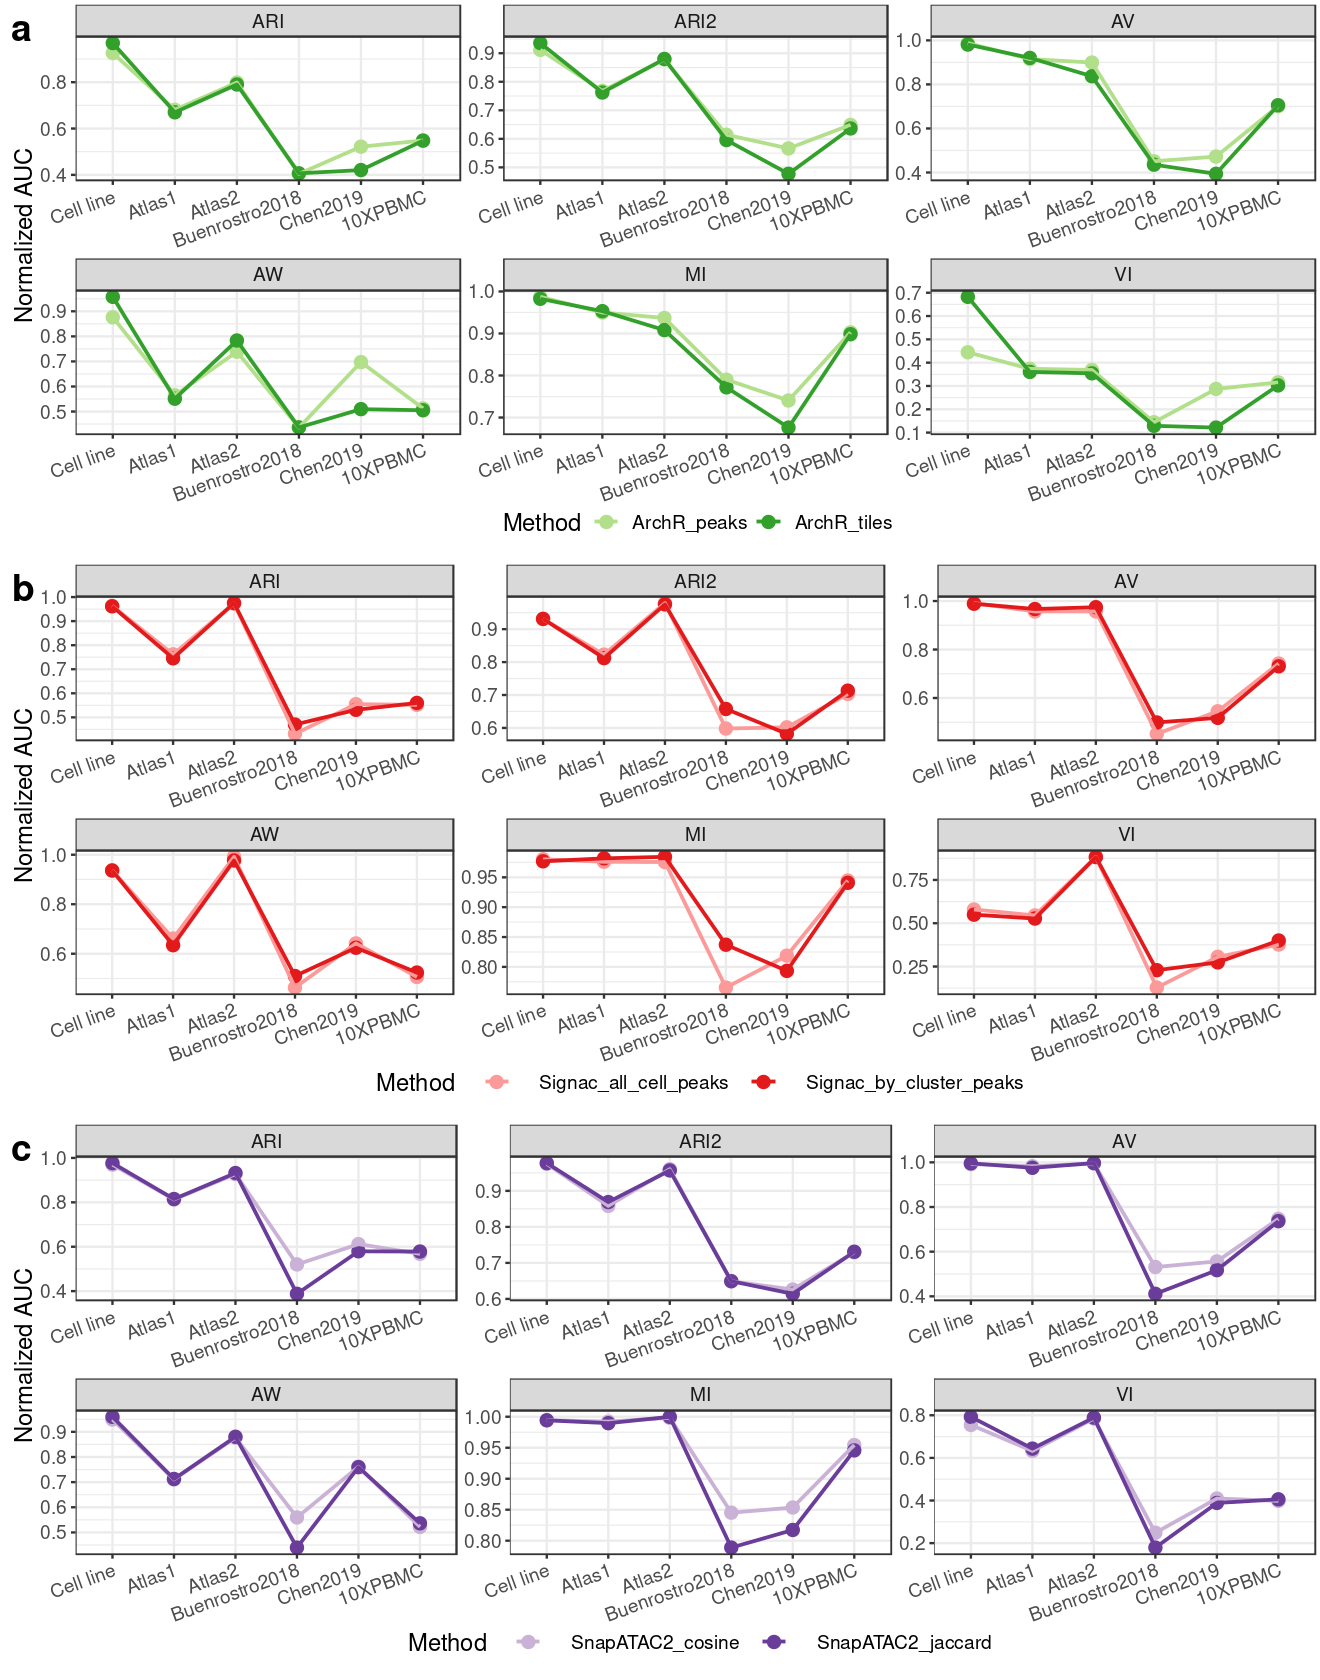

In [53]:
library(ggpubr)
options(repr.plot.width=11, repr.plot.height=14)
p4 <- ggarrange(p1, p2, p3, 
          labels = c("a", "b", "c"),font.label=list(color="black",size=22, face="bold"),
          ncol = 1, nrow = 3)
p4

In [262]:
pdf(paste0("FigS6.pdf"), width=11, height=14)
print(p4)
dev.off() 

png 
  2